# This notebook is for using the bayesian network

### f_0 function for loading images

In [20]:
from PIL import Image
import os
import numpy as np

def load_data(load_file_path):
    # Funktion zum Laden von Daten aus dem Ordner load_file_path als TIFF
    # Argument: load_file_path als String
    image_array = []  # Leeres Array zum Speichern der Bilder

    # Iteriere über die Dateien im Ordner
    for file_name in os.listdir(load_file_path):
        file_path = os.path.join(load_file_path, file_name)

        # Überprüfe, ob die Datei ein unterstütztes Bildformat hat
        if file_name.endswith(('.png', '.PNG', '.jpg', '.JPG', '.jpeg', '.JPEG', '.tiff', '.TIFF', '.tif', '.TIF')):
            # Lade das Bild mit PIL
            pil_image = Image.open(file_path)

            # Überprüfe den Datentyp des Bildes
            if isinstance(pil_image, np.ndarray):
                # Wenn das Bild bereits ein NumPy-Array ist, füge es direkt zum Array hinzu
                image_array.append(pil_image)
            else:
                # Wenn das Bild ein PIL Image-Objekt ist, konvertiere es in ein NumPy-Array und füge es hinzu
                image_array.append(np.array(pil_image))

    return image_array

### f_1 function for plotting 

In [21]:
import math
import matplotlib.pyplot as plt

def visualization_w_plt_subplots(array_images, array_titles, subplot_column_num, subplot_width, subplot_height):
    # This function is used to visualize the results using Matplotlib.
    # Visualization of results using Matplotlib
    row_num = math.ceil(len(array_images) / subplot_column_num)
    num_name = 0
    if len(array_titles)==0:
        array_titles = []
        for title in range(len(array_images)):
            title = str(num_name+1)
            array_titles.append(title)
            num_name = num_name + 1

    if row_num == 1 and subplot_column_num == 1:
        plt.figsize=(subplot_width, subplot_height)
        plt.imshow(array_images[0])
        plt.title(array_titles[0])
    else:
        if subplot_column_num == 1:
            # Create subplots with a single coloumn
            fig, axes = plt.subplots(row_num, 1, figsize=(subplot_width, subplot_height))
            for j in range(len(array_images)):
                axes[j].imshow(array_images[j])
                axes[j].set_title(array_titles[j])
        
        else:
            if row_num == 1 or row_num < 0:
                # Create subplots with a single row
                fig, axes = plt.subplots(1, subplot_column_num, figsize=(subplot_width, subplot_height))
                for j in range(len(array_images)):
                    axes[j].imshow(array_images[j])
                    axes[j].set_title(array_titles[j])
            else:
                # Create subplots with multiple rows
                fig, axes = plt.subplots(row_num, subplot_column_num, figsize=(subplot_width, subplot_height))

                for i in range(row_num):
                    start_index = i * subplot_column_num
                    end_index = min((i + 1) * subplot_column_num, len(array_images))
                    images = array_images[start_index:end_index]
                    titles = array_titles[start_index:end_index]

                    for j in range(len(images)):
                        axes[i, j].imshow(images[j])
                        axes[i, j].set_title(titles[j])

                    # Hide the remaining subplots if there are fewer than subplot_column_num images in the group
                    if len(images) < subplot_column_num:
                        for k in range(len(images), subplot_column_num):
                            axes[i, k].axis("off")

    plt.tight_layout()
    plt.show()

# 1. Loading CSV data

In [22]:
import pandas as pd

csv_file_path = r"C:\Users\SeppG\VdKI\00_project_abgabe\00_data\99_testing_images_for_CSV\Testing_Data_CSV.csv"
# Lade die CSV-Datei in einen DataFrame und verwende die erste Zeile als Header
data_frame = pd.read_csv(csv_file_path, header=0)

feature_columns = ['con_num', 'con_area', 'orb_num_front', 'orb_num_back', 'cs_green', 'cs_yellow', 'cs_white', 'cs_purple', 'cs_red', 'cs_blue', 'cs_brown',
                    'mod_length', 'mod_length_wo_white', 'mod_area', 'mod_area_wo_white']  # Liste der aller Featurespalten
feature_columns = [ 'con_num', 'con_area', 'orb_num_front', 'orb_num_back', 'cs_green', 'cs_yellow', 'cs_white', 'cs_purple', 'cs_red', 'cs_blue', 'cs_brown'] # Liste der gewählten Featurespalten


# Extrahiere  die Features x_all aus dem DataFrame
x_all = data_frame.loc[:, feature_columns]

# 2. Loading Bayesian network model from scikit-learn and applying it to x_all

In [23]:
import pickle
# Lade das trainierte Modell aus der Dateinpfad
saving_file_path_bayesian_network = r'C:\Users\SeppG\VdKI\00_project_abgabe\03_kis\01_bayes\bayesian_network_testing_1.pkl'
loaded_bayes_classifier = pickle.load(open(saving_file_path_bayesian_network, 'rb'))
# Predictions erzeugen
y_predictions_bn_lib = loaded_bayes_classifier.predict(x_all)

## 2.1 Visualization of predictions

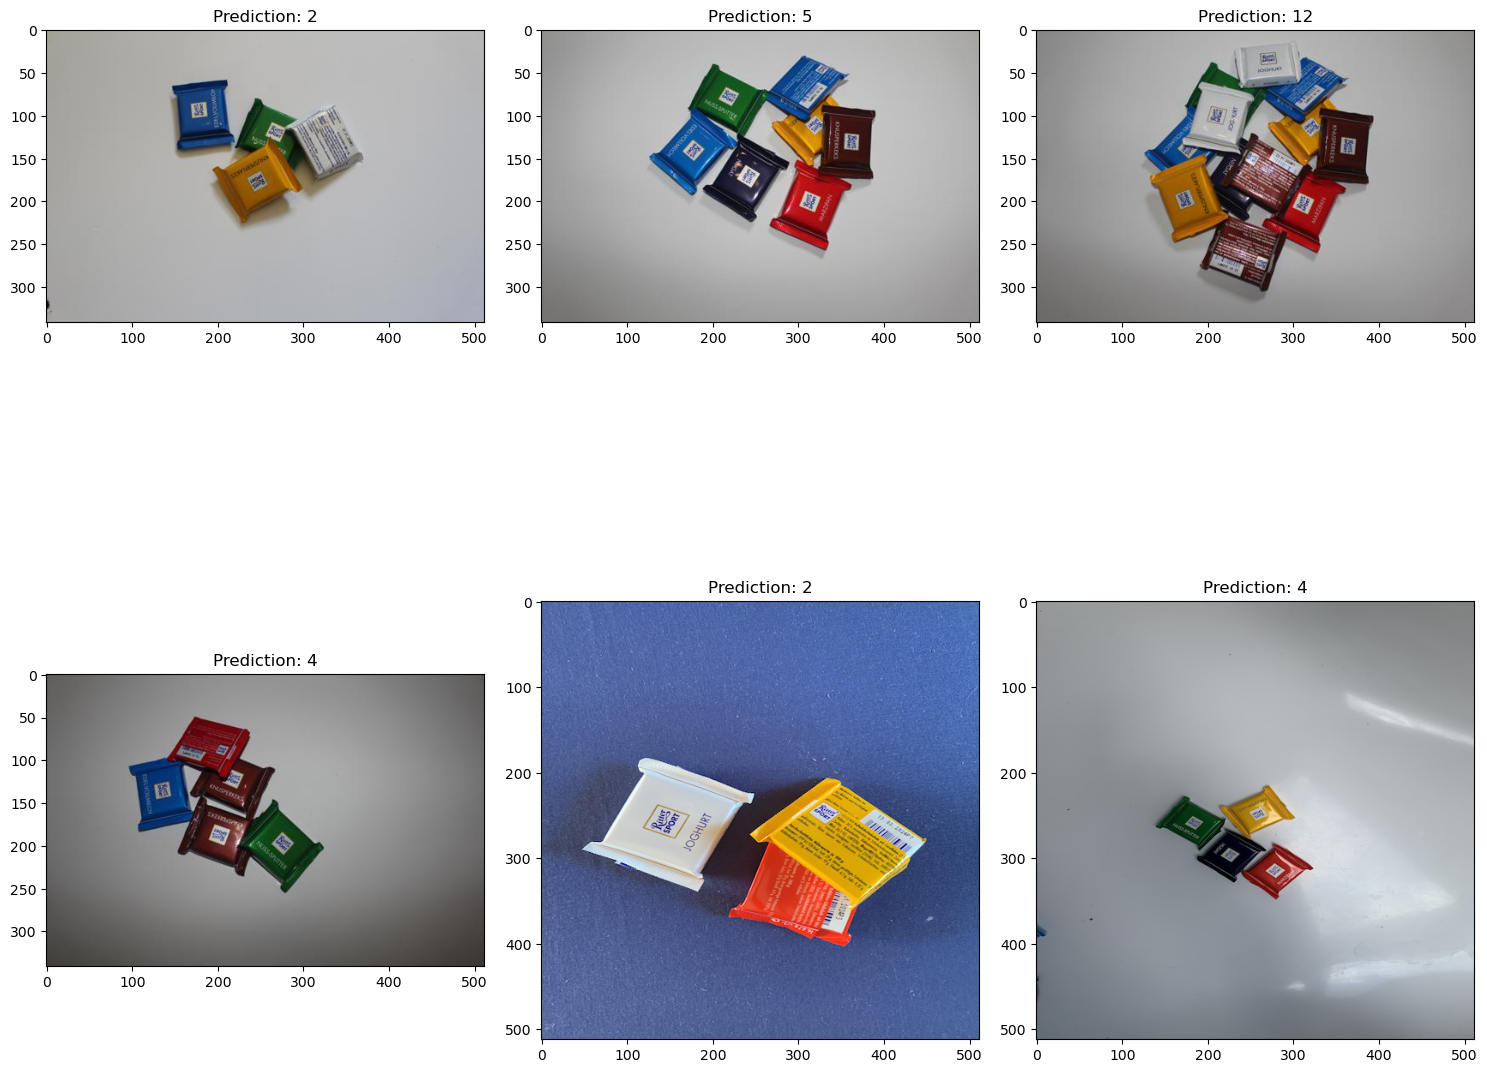

In [24]:
load_file_path = r"C:\Users\SeppG\VdKI\00_project_abgabe\00_data\99_testing_images_for_CSV\Test_Bilder"
array_images_rgb = load_data(load_file_path)

y_predictions_titles = []
for i in range(len(array_images_rgb)):
    title = "Prediction: " + str(y_predictions_bn_lib[i])
    y_predictions_titles.append(title)

visualization_w_plt_subplots(array_images_rgb, y_predictions_titles, 3, 15, 15)

# 3.0 Selfprogrammed bayesian network

In [25]:
import numpy as np
import math
import pandas as pd
import os

import numpy as np

def cholesky_inverse(matrix):
    # Cholesky-Zerlegung
    L = np.linalg.cholesky(matrix)
    
    # Inverse der unteren Dreiecksmatrix
    L_inv = np.linalg.inv(L)
    
    # Inverse der Matrix durch Rücktransformation
    matrix_inv = np.dot(L_inv.T, L_inv)
    
    return matrix_inv

class Bayes_features_independent_probability:
    def __init__(self):
        # Initialize dictionaries to store mean and variance for each class
        self.mean_values = {}
        self.variance_values = {}
               
    def fit2(self, features, classes):
        # Get unique classes
        unique_classes = classes.unique()
        num_columns = len(features.columns)

        for class_label in unique_classes:
            # Filter features belonging to the current class
            features_of_class = features[classes == class_label]
            mean_values = []
            variance_values = []
            
            # Calculate the MEAN value and VARIANCE for each column
            for column in range(num_columns):
                mean_value = 1 / len(features_of_class) * sum(features_of_class.iloc[:, column])
                variance_value = 1 / len(features_of_class) * sum((features_of_class.iloc[:, column] - mean_value) ** 2)
                mean_values.append(mean_value)
                variance_values.append(variance_value)

            # Store the mean and variance for the current class
            self.mean_values[class_label] = mean_values
            self.variance_values[class_label] = variance_values
            
    def save2(self, path):
        # Save the trained model data to files
        np.save(os.path.join(path, 'mean_values.npy'), self.mean_values)
        np.save(os.path.join(path, 'variance_values.npy'), self.variance_values)
    
    def load2(self, path):
        # Load the trained model data from files
        self.mean_values = np.load(os.path.join(path, 'mean_values.npy'), allow_pickle=True).item()
        self.variance_values = np.load(os.path.join(path, 'variance_values.npy'), allow_pickle=True).item()
        
    def predict2(self, x_test):
        predictions = []
        probability_list = []
        for i in range(len(x_test)):
            probability_densities = []
            classes = self.mean_values.keys()
            for class_label in classes:
                # Calculate the probability density for each class assuming independent features
                feature_vector = np.array(x_test.iloc[i, :])
                probabilities = []
                for j in range(len(feature_vector)):
                    mean = self.mean_values[class_label][j]
                    variance = self.variance_values[class_label][j]
                    probability = 1 / (math.sqrt(2 * math.pi * variance)) * math.exp(-(feature_vector[j] - mean) ** 2 / (2 * variance))
                    probabilities.append(probability)
                probability_densities.append(np.prod(probabilities))

            # Normalize the probabilities to ensure they form a valid probability distribution
            probability_densities_sum = sum(probability_densities)
            probabilities = [probability_densities[i] * 1 / len(self.mean_values) / probability_densities_sum for i in range(len(self.mean_values))]
            highest_index = max(range(len(probabilities)), key=probabilities.__getitem__)
            # Append the predicted class label and its corresponding probability to the result lists
            predictions.append(list(self.mean_values.keys())[highest_index])
            probability_list.append(probabilities[highest_index])
        return predictions

    def test_accuracy2(self, predictions, y_test):
        predictions = pd.DataFrame(predictions, index=y_test.index, columns=["label"])
        y_test = y_test.to_frame()
        score = 0
        for index in y_test.index:
            row1 = predictions.loc[index]
            row2 = y_test.loc[index]
            # Check if the predicted class label matches the true class label
            score += int(row1[0] == row2[0])
        # Compute the accuracy score by dividing the total correct predictions by the number of samples
        accuracy = score / len(predictions)
        return accuracy



### 3.1 Loading trained BN and predictiong the number of Rittersporttafeln

In [26]:
# loading and testing bayesian network
model_loaded = Bayes_features_independent_probability()

model_loaded.load2(r'C:\Users\SeppG\VdKI\00_project_abgabe\03_kis\01_bayes')

predictions_self_programmed_2 = model_loaded.predict2(x_all)

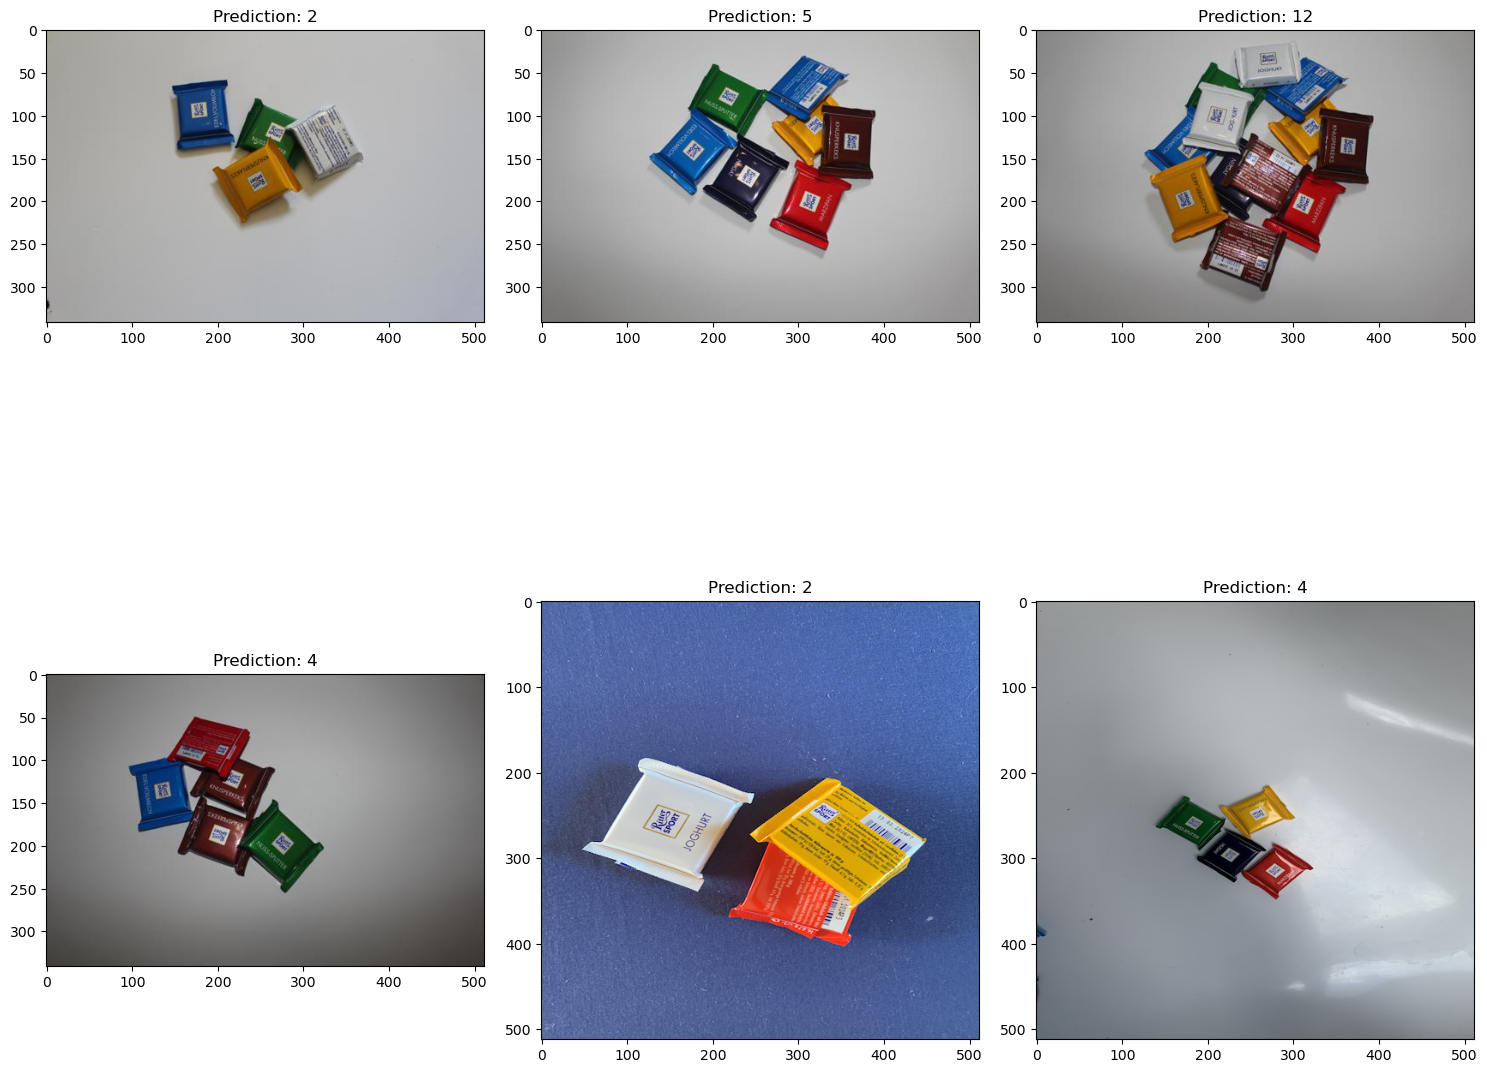

In [27]:
load_file_path = r"C:\Users\SeppG\VdKI\00_project_abgabe\00_data\99_testing_images_for_CSV\Test_Bilder"
array_images_rgb = load_data(load_file_path)

y_predictions_titles_2 = []
for i in range(len(array_images_rgb)):
    title = "Prediction: " + str(predictions_self_programmed_2[i])
    y_predictions_titles_2.append(title)

visualization_w_plt_subplots(array_images_rgb, y_predictions_titles_2, 3, 15, 15)